In [1]:
import os  
os.chdir('../')

In [2]:
# import pandas as pd 
# import geopandas 
import yaml
import geopandas as gpd
import pandas as pd
import shutil

from pilates.utils.geog import get_block_geoms, get_mass_transit_stations
from pilates.urbansim.preprocessor import usim_model_data_fname

In [3]:
with open('settings.yaml') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
settings['region'] = 'sfbay'
settings['skims_zone_type'] = 'block'

In [5]:
blocks = get_block_geoms(settings)
stations = get_mass_transit_stations(settings)

blocks.set_index('GEOID', inplace = True)

## TOD Development 
Literature suggest a 1/2 mile around transit stations (800 meters) 

http://www.tod.org/placemaking/principles.html

In [22]:
#Check CRS of the two dataframes are the same, and project to meters. 
assert stations.crs == blocks.crs, "CRS is not the same"
stations_meters = stations.to_crs('EPSG:7131')
blocks_meters = blocks.to_crs('EPSG:7131')

#Draw the buffers
stations_buffer = stations_meters.geometry.buffer(800)#.plot(figsize = (20,20))

# mass_transit_blocks = b_meters.sjoin(s_meters, how ='left', predicate = 'intersects')
mass_transit_blocks = gpd.clip(blocks_meters.geometry, stations_buffer, keep_geom_type = True)
mass_transit_blocks.index.name = 'block_id'

In [23]:
blocks_meters['mass_transit_block'] = blocks_meters.index.isin(mass_transit_blocks.index)

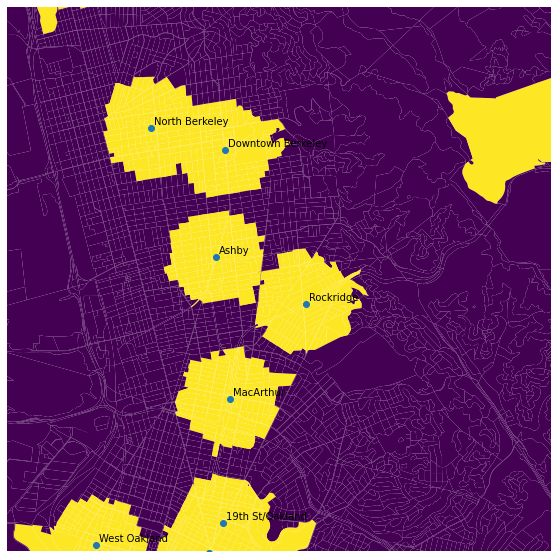

In [24]:
ax = blocks_meters.plot(column = 'mass_transit_block', figsize = (10,10))#, cmap =  'pink')
stations_meters.plot(ax = ax)

for x, y, label in zip(stations_meters.geometry.x, stations_meters.geometry.y, stations_meters.stop_name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_xlim(60000, 70000)
ax.set_ylim(30000, 40000)

ax.set_axis_off();

In [25]:

## TO DO: Save result in utils to use it often 
def get_transit_stations_blocks(settings):
    settings_copy = settings.copy()
    settings_copy['skims_zone_type'] = 'block'
    region = settings_copy['region']
    
    mass_transit_blocks_fname = 'pilates/utils/data/{}/mass_transit_blocks.csv'.format(region)
    exist  = os.path.exists(mass_transit_blocks_fname)
    
    if exist: 
        df = pd.read_csv(mass_transit_blocks_fname)
        blocks_id = list(df['GEOID'])
    
    else: 
        #Spatial match of stations buffers and blocls 
        stations = get_mass_transit_stations(settings)
        blocks = get_block_geoms(settings)
        blocks.set_index('GEOID', inplace = True)
    
        assert stations.crs == blocks.crs, "CRS is not the same"
        stations_meters = stations.to_crs('EPSG:7131')
        blocks_meters = blocks.to_crs('EPSG:7131')

        #Draw the buffers
        stations_buffer = stations_meters.geometry.buffer(800)
        # mass_transit_blocks = b_meters.sjoin(s_meters, how ='left', predicate = 'intersects')
        mass_transit_blocks = gpd.clip(blocks_meters.geometry, stations_buffer, keep_geom_type = True)
        mass_transit_blocks = mass_transit_blocks.reset_index().drop(columns ='geometry')
        mass_transit_blocks.to_csv(mass_transit_blocks_fname, index = False)
        blocks_id = list(mass_transit_blocks['GEOID'])
        
    return blocks_id

In [ ]:
mass_transit_blocks = get_transit_stations_blocks(settings)

In [ ]:
len(mass_transit_blocks)

## Modify model data

In [ ]:
def read_model_data(settings, data_dir = None):
    region = settings['region']
    region_id = settings['region_to_region_id'][region]
    model_data_fname = usim_model_data_fname(region_id)
    
    if not data_dir:
        data_dir = settings['usim_local_data_folder']
    
    model_data_fpath = os.path.join(data_dir, model_data_fname)
   
    if not os.path.exists(model_data_fpath):
        raise ValueError('No input data found at {0}'.format(
            model_data_fpath))
    
    store = pd.HDFStore(model_data_fpath)
    return store

In [ ]:
def tod_residential(settings, factor):
    
    store = read_model_data(settings)
    blocks = store['/blocks']
    
    mass_transit_block = get_transit_stations_blocks(settings)
    
    new_blocks = modify_block_capacity(blocks, 'residential_unit_capacity', 
                                       factor, mask = mass_transit_block)

    #save blocks table in store
    store.put('/blocks', new_blocks)
    store.close()
    
def tod_employment(settings, factor):
    
    store = read_model_data(settings)
    blocks = store['/blocks']
    
    mass_transit_block = get_transit_stations_blocks(settings)
    
    new_blocks = modify_block_capacity(blocks, 'employment_capacity', 
                                       factor, mask = mass_transit_block)

    #save blocks table in store
    store.put('/blocks', new_blocks)
    store.close()

In [ ]:
def modify_block_capacity(blocks, capacity_col, factor, mask = None):
    """
    Returns blocks tables with capacity_col modify by "factor". 
    If mask is define, it only modifies the blocks include in mask list. 
    
    Parameters: 
    -----------
    - blocks: DataFrame. Blocks tables. Block ID is set at index 
    - capacity_col: 
    - factor: 
    - mask: list. List of blocks ID to modify capacities. 
    """
    
    assert blocks.index.name == 'block_id'
    assert capacity_col in blocks.columns
    
    blocks = df.copy()
    if mask is None: 
        df[capacity_col] = df[capacity_col] * factor
        
    else: 
        mask_col
        mask_col = df.index.isin(mask).astype(bool)
        df[capacity_col] = df[capacity_col].mask(mask_col,df[capacity_col] * factor)
    return df

In [ ]:
import os
from shutil import copyfile

In [ ]:
#Copy File 
copyfile('../pilates/urbansim/data/custom_mpo_06197001_model_data.h5',
         '../pilates/urbansim/data/custom_mpo_06197001_model_data_employment_mass_transit.h5')



In [ ]:
print ('hola')

In [ ]:
hdf = read_model_data(settings, data_dir = None)